<a href="https://colab.research.google.com/github/maquico/IA-IDS330/blob/main/ids330l_semana08_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IDS330 | Redes Recurrentes

In [1]:
# Angel Moreno ID 1104666
import torch

En Pytorch, las capas de RNN se definen con el paquete `torch.nn.RNN`.

https://pytorch.org/docs/stable/generated/torch.nn.RNN.html

**Parametros**
* input_size: el numero de features en la entrada x
* hidden_size: la dimension del estado oculto *h*
* num_layers: numero de capas recurrentes
* bidirectional: (bool) si `True`, la red es bidirectional
* batch_first; (bool) si `True`, el input y el output tendran una dimension `(batch_size, seq_len, feature_size)`

**Input**
* input: dimension de `(batch_size, seq_len, feature_size)`, si `batch_first = True`
* h0: tensor que contiene el estado oculto inicial. Su dimension es de `(num_layers * num_directions, batch_size, hidden_size)`

**Output**
* output: tensor que contiene los *features* de la ultima capa de la RNN. Tiene dimension de `(batch_size, seq_len, feature_size)`, si `batch_first = True`
* hn: tensor que contiene el estado oculto final. Su dimension es de `(num_layers * num_directions, batch_size, hidden_size)`

In [2]:
## RNN de una sola capa
# input_size = 5
# seq_len = 10
# hidden_size = 2

# Input
x = torch.rand(1, 10, 5)  # (batch_size -> cantidad de datos en el batch, seq_len -> longitud de la secuencia , feature_size -> longitud del vector que representa cada palabra)
# Estado inicial
h0 = torch.rand(1, 1, 2)
# Red
rnn = torch.nn.RNN(input_size=5, hidden_size=2, num_layers=1, bidirectional=False, batch_first=True)
# Output y Estado Final
output, h_n = rnn(x, h0)


In [3]:
## RNN de una sola capa
# num_layers = 2
# bidirectional = True
# input_size = 5
# seq_len = 10
# hidden_size = 2

x = torch.rand(1, 10, 5)  # (batch_size, seq_len, feature_size)
h0 = torch.rand(2*2, 1, 2)
rnn = torch.nn.RNN(input_size=5, hidden_size=2, num_layers=2, bidirectional=True, batch_first=True)
output, h_n = rnn(x, h0)

## Descargar la data

In [4]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.3 MB/s eta 0:00:00


In [5]:
from datasets import load_dataset
dataset = load_dataset("5cp/imdb_review_prompts", trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/782 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/858 [00:00<?, ? examples/s]

In [6]:
train_texts = dataset['train']['text']
train_labels = dataset['train']['label']
test_texts = dataset['test']['text']
test_labels = dataset['test']['label']

In [7]:
train_texts = [text.split('###')[2].replace('Review: ', '') for text in train_texts]
test_texts = [text.split('###')[2].replace('Review: ', '') for text in test_texts]


## Preprocesamiento

In [8]:
from string import punctuation
from collections import Counter
import numpy as np



train_reviews = [review.lower() for review in train_texts]
test_reviews = [review.lower() for review in test_texts]
train_reviews = [''.join([c for c in review if c not in punctuation]) for review in train_reviews]
test_reviews = [''.join([c for c in review if c not in punctuation]) for review in test_reviews]

all_texts = ' '.join(train_reviews + test_reviews) # al sumar listas se concatenan
words = all_texts.split()
count_words = Counter(words)
sorted_words = count_words.most_common(len(words))
vocab_to_int = {word:i+1 for i, (word,c) in enumerate(sorted_words)}



In [9]:
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [10]:
train_reviews_int = []
for review in train_reviews:
    r = [vocab_to_int[word] for word in review.split()]
    train_reviews_int.append(r)

test_reviews_int = []
for review in test_reviews:
    r = [vocab_to_int[word] for word in review.split()]
    test_reviews_int.append(r)


In [11]:
## el padding es agregar 0s a vectores o matrices
def pad_sequence(reviews_int: list, seq_len: int) -> np.array:

    features = np.zeros((len(reviews_int), seq_len), dtype=int)

    for i, review in enumerate(reviews_int):
        review_len = len(review)

        if review_len <= seq_len:
            zeroes = list(np.zeros(seq_len - review_len))
            new_review = zeroes + review # agregar 0 a vectores de palabras que sean cortos
        else:
            new_review = review[:seq_len] # recortar reviews muy largas
        features[i,:] = np.array(new_review)

    return features


In [12]:
padded_train_reviews = pad_sequence(train_reviews_int, 100)
padded_test_reviews = pad_sequence(test_reviews_int, 100)

## Cargar como Dataset

In [13]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64

# Se transforman los datos en tensores que tienen en la primera posicion la review y en la segunda su label
train_data = TensorDataset(torch.from_numpy(padded_train_reviews), torch.from_numpy(train_labels))
test_data = TensorDataset(torch.from_numpy(padded_test_reviews), torch.from_numpy(test_labels))

# Para el entrenamiento se usa el shuffle True porque en la data original estan todos los negativos juntos y todos los positivos juntos
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# Para el test no es necesario el shuffle
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)



In [14]:
# Check the data
batch = next(iter(train_loader))
x, y = batch

print("Input size:", x.size())
print("Input:", x)

print("Output size:", y.size())
print("Output:", y)


Input size: torch.Size([64, 100])
Input: tensor([[   0,    0,    0,  ..., 1166, 2828,   62],
        [   0,    0,    0,  ...,   12,   31,  416],
        [   0,    0,    0,  ...,  861,  378, 4294],
        ...,
        [   0,    0,    0,  ...,   26,  918,  131],
        [   0,    0,    0,  ..., 2718, 4748, 4749],
        [   0,    0,    0,  ...,  770,   25,   33]])
Output size: torch.Size([64])
Output: tensor([1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
        1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
        0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0])


## Definir Red Recurrente

In [59]:
# torch.nn.LSTM(x, (h0, c0))

In [60]:
class SentimentAnalysis(torch.nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int, output_size: int, hidden_dim: int, num_layers: int):
        super().__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.output_size = output_size # en nuestro caso 2, positivo o negativo

        self.embedding = torch.nn.Embedding(
            vocab_size, # cantidad de palabras en el vocabulario
            embedding_dim, # valor arbitrario
            padding_idx = 0) # valor con el que hicimos padding

        self.rnn = torch.nn.LSTM(
            embedding_dim, # representa el input size
            hidden_dim,
            num_layers,
            batch_first=True)

        self.linear = torch.nn.Linear(hidden_dim, output_size)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x, h0):
        embeddings = self.embedding(x) # convertir cada palabra a su embedding
        output, h_n = self.rnn(embeddings, h0) # pasamos estos embeddings y el estado inicial a la rnn
        output = self.linear(output[:,-1,:]) # pasar por capa lineal para obtener 2 valores (positivo o negativo)
        output = self.sigmoid(output) # pasar por sigmoide para convertir output anterior en probabilidad
        return output



## Entrenamiento

In [68]:
vocab_size = len(vocab_to_int) + 1   # +1 por el padding '0'
output_size = 1

### PUEDEN CAMBIAR ###
embedding_dim = 300
hidden_dim = 196
num_layers = 3
######################

model = SentimentAnalysis(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    output_size=output_size,
    hidden_dim=hidden_dim,
    num_layers=num_layers)

learning_rate = 0.01
num_epochs = 10

loss_function = torch.nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model.cuda()

losses = []
accuracies = []
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        inputs = inputs.cuda()
        labels = labels.cuda()

        batch_size = inputs.size(0)

        h0 = torch.randn(num_layers*1, batch_size, hidden_dim)
        h0 = h0.cuda()
        c0 = torch.zeros(num_layers*1, batch_size, hidden_dim)
        c0 = c0.cuda()

        outputs = model(inputs, (h0, c0))

        loss = loss_function(outputs.squeeze(), labels.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = (outputs.squeeze() > 0.5).float()
        acc = torch.mean((pred == labels).float())

        losses.append(loss.item())
        accuracies.append(acc.item())


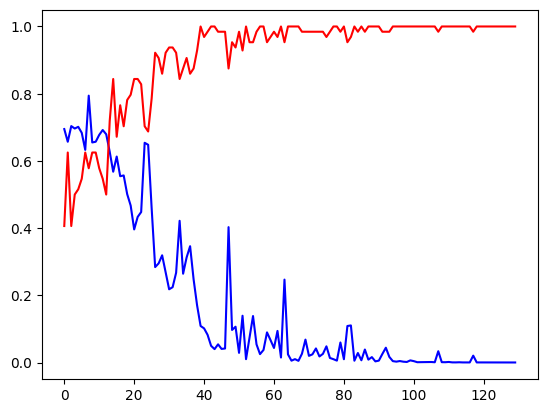

In [69]:
import matplotlib.pyplot as plt

plt.plot(losses, 'b')
plt.plot(accuracies, 'r')
plt.show()

In [70]:
model.eval()
accuracy = 0
total_inputs = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.cuda()
        labels = labels.cuda()

        batch_size = inputs.size(0)

        h0 = torch.randn(num_layers*1, batch_size, hidden_dim)
        h0 = h0.cuda()
        c0 = torch.zeros(num_layers*1, batch_size, hidden_dim)
        c0 = c0.cuda()

        outputs = model(inputs, (h0, c0))

        pred = (outputs.squeeze() > 0.5).float()
        acc = torch.sum((pred == labels).float())
        total_inputs += inputs.size(0)
        accuracy += acc.item()

print(f"Accuracy: {100*accuracy/total_inputs:.2f}%")


Accuracy: 72.96%


In [71]:
import random

def int_to_voc(val, my_dict):
    for key, value in my_dict.items():
        if val == value:
            return key

model.cpu()
review, label = random.choice(train_data)
review_sentence = ' '.join([int_to_voc(r, vocab_to_int) for r in review if r != 0])
print(review_sentence)

print("Actual label:", 'negative' if label.item() == 0 else 'positive')

h0 = torch.randn(num_layers*1, 1, hidden_dim)
c0 = torch.randn(num_layers*1, 1, hidden_dim)
output = model(review.unsqueeze(0), (h0, c0))
sentiment = 'negative' if output <= 0.5 else 'positive'
print("Pred Sentiment:", sentiment)



this film is not even worth walking to the movie theatre no jokes but stupid and boring laughing on repeated disgusting stuff the music and the girls are great unfortunately you have to watch the whole movie to enjoy them it was weak very very weak
Actual label: negative
Pred Sentiment: negative
